# Downloading objects from MS COCO

This scripts imports images from the _MS COCO image database_, segments out objects from the images based on input object categories, and downloads the result as a full object on a plain background.

More precisely, here is how it does it:
1. Images are imported from the **train2017 dataset**. Those images (a) contain instances from the categories that are set as input, and (b) _only_ contain _one_ instance from these categories.
2. From the COCO annotations, objects are segmented out from the rest of the images.
3. The result is images containing only objects on plain backgrounds. Those are then downloaded locally.

### Preamble

Define here the **categories** you wish to downloads objects from, as well as the **number** of images to download per category.
- Input object categories by the index number as referenced here: https://tech.amikelive.com/node-718/what-object-categories-labels-are-in-coco-dataset/ . Input these numbers in place of `cat_indices`.
- Name a number of images to download per category. Remember that categories usually contain a few thousand images. Input that number in place of `nrb_im`.

_Note that you still need to manually download the images.zip file and place it in a relevant directory locally._

In [88]:
# categories
cat_indices = [6, 21, 41, 49, 85, 1] # example indices: 6 for busses, 17 for cats

# number of images per object category
nbr_im = 100

### 1. Download the required data from MS COCO

The following cells download the required databases from MS COCO (check out the source from on https://cocodataset.org/#home). This means the images themselves (from the **train2017** database), but also the linked annotations (**annotations_trainval2017**).

Note that this initial downloading and unarchiving phase will take a while.

In [1]:
# here I download the massive train2017 dataset from ms coco
!wget http://images.cocodataset.org/zips/train2017.zip

--2022-04-19 09:17:21--  http://images.cocodataset.org/zips/train2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.135.11
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.135.11|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19336861798 (18G) [application/zip]
Saving to: ‘train2017.zip’

train2017.zip       100%[===================>]  18.01G   135MB/s    in 3m 15s  

2022-04-19 09:20:36 (94.4 MB/s) - ‘train2017.zip’ saved [19336861798/19336861798]



In [2]:
# here I download the linked annotations
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-04-19 09:20:37--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.202.137
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.202.137|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  96.3MB/s    in 2.5s    

2022-04-19 09:20:39 (96.3 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]



In [ ]:
# here I unzip both downloads
!unzip train2017.zip
!unzip annotations_trainval2017.zip

### 2. Packages

The following cells install and load some necessary libraries.

In [ ]:
# get the required packages
!pip install pycocotools
!pip install mxnet
!pip install gluoncv
print("All packages installed.")

In [11]:
# import some packages and tools
import cv2 as cv
# from gluoncv import data, utils
from pycocotools.coco import COCO
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from google.colab import files
np.random.seed()
print("All packages loaded.")

All packages loaded.


### 3. Listing relevant images

The following cells import the downloaded images and their annotations into memory. Note that this next cell might also take a bit of time to run.

In [74]:
# first link to the downloaded images and load the annotations into a readable format
img_dir = ('train2017') # loads the downloaded dataset, change if using sth else than 'train2017'
coco_annotations = COCO('annotations/instances_{}.json'.format(img_dir))

loading annotations into memory...
Done (t=30.79s)
creating index...
index created!


### 4. Reading, segmenting and writing images

**This cell does the whole thing all**. It reads the images, segments out the object they contain, pastes it on a plain, transparent background, and writes the result.

It will even tell you how many images COCO contains with the given object in it.

In [79]:
# create the writing directory
write_dir = ('write')
if not os.path.exists(write_dir):
  os.makedirs(write_dir)

for category in cat_indices:

  # extract the name of the current category
  cat_name = coco_annotations.loadCats(category)[0]['name']
  # create a list of images that contain *one* instance of the input object categories 
  img_ids = coco_annotations.getImgIds(catIds=category) # create a list of all the images containing the corresponding object category
  np.random.shuffle(img_ids) # randomize the list not to always get the same images
  print('There are', (len(img_ids)), 'images containing exactly one instance from the', cat_name, 'category')
  
  # avoid that the desired number of images is higher than the number of available ones
  if nbr_im > len(img_ids):
    nrb_im = len(img_ids)
  
  img_ids = img_ids[0:nbr_im] # only pick as many images as desired

  # create a number to add to the image name
  image_nbr = 1

  # take in images and segment out the object they contain

  for i in img_ids:
    img = coco_annotations.imgs[i]

    cat_ids = coco_annotations.getCatIds(catIds = category)
    anns_ids = coco_annotations.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
    anns = coco_annotations.loadAnns(anns_ids)

    mask = coco_annotations.annToMask(anns[0])
    for j in range(len(anns)):
        mask += coco_annotations.annToMask(anns[j])
        mask = cv.normalize(mask, None, 0, 255, cv.NORM_MINMAX, cv.CV_8U)
    
    pic = cv.imread('{}/'.format(img_dir) + str(list(img.values())[1]), 0)
    transparent = mask[:] != 255
    mask[transparent] = 0
    pic = cv.bitwise_and(pic, mask)

    # here I create an alpha channel that masks everything but the object
    a = np.ones((pic.shape[0], pic.shape[1]), np.uint8)
    a[:]=255
    a[transparent] = 0

    # here I create a 4-channel version of the object where the background is alpha = 0
    pic_a = cv.merge((pic, pic, pic, a))

    # finally I write this 4-channel version of the image
    cv.imwrite('{}/'.format(write_dir) + cat_name + str(image_nbr) + '.png', pic_a)

    # amend the index number
    image_nbr += 1


There are 3952 images containing exactly one instance from the bus category
There are 1968 images containing exactly one instance from the cow category
There are 3476 images containing exactly one instance from the skateboard category
There are 4326 images containing exactly one instance from the knife category
There are 4659 images containing exactly one instance from the clock category
There are 64115 images containing exactly one instance from the person category


KeyError: ignored

### 5. Downloading the result

And finally, download the result with the following cell.

In [71]:
# here I download the folder containing segmented objects

!zip -r /content/images.zip /content/write # start by archiving the folder to download
files.download("/content/images.zip") # then download it

# note that you still need to manually download the images.zip file and place it in a relevant directory locally

updating: content/write/ (stored 0%)
updating: content/write/bus6.png (deflated 38%)
updating: content/write/cat3.png (deflated 32%)
updating: content/write/bus2.png (deflated 26%)
updating: content/write/cat8.png (deflated 31%)
updating: content/write/.ipynb_checkpoints/ (stored 0%)
updating: content/write/cat1.png (deflated 35%)
updating: content/write/bus3.png (deflated 25%)
updating: content/write/cat4.png (deflated 29%)
updating: content/write/bus7.png (deflated 31%)
updating: content/write/bus10.png (deflated 41%)
updating: content/write/cat9.png (deflated 26%)
updating: content/write/bus1.png (deflated 27%)
updating: content/write/bus9.png (deflated 25%)
updating: content/write/bus8.png (deflated 24%)
updating: content/write/bus4.png (deflated 23%)
updating: content/write/cat5.png (deflated 24%)
updating: content/write/cat2.png (deflated 28%)
updating: content/write/cat7.png (deflated 26%)
updating: content/write/bus5.png (deflated 25%)
updating: content/write/cat6.png (deflated

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

**Optional cell**

_Note that this cell will display an image from the last category in the category indices list. It's not really useful anymore but it looks nice._

The cell below allows to quickly visualize any given image from the list we just created. Use it as a safety check to make sure the object you're looking for is present in the pictures.

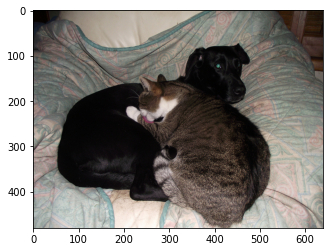

In [63]:
# just a quite script to visualize an image given its image id
random_number = np.random.randint(0, len(img_ids)) # choose a random image
image_id = img_ids[random_number] # display a random image

# check if the displayed image contains an expected object
img = coco_annotations.imgs[image_id]
image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image)
plt.show()

**Credits**

This script was highly inspired by the two following sources:
1. This thread: https://stackoverflow.com/questions/50805634/how-to-create-mask-images-from-coco-dataset
2. This video: https://www.youtube.com/watch?v=uq4F9PIeZB0&t=950s